In [30]:
import numpy as np
from scipy import optimize
from scipy import integrate
from numpy import random
import matplotlib.pyplot as plt
import time

In [31]:
def planck(x):
    return 15/np.pi**4 * x**3/(np.exp(x)-1)


def planckDerivative(x):
    return 15/np.pi**4*x**2 * (3*(np.exp(x)-1)-x*np.exp(x))/(np.exp(x)-1)**2

In [32]:
# Calculating the maximum of the planck distribution
x_max = optimize.brentq(planckDerivative,0.01,10)
y_max = planck(x_max)
print(x_max)
print(y_max)

2.8214393721220787
0.218886470091


In [33]:
# Defining the majorant which is used in b
def majorant(x, x_s, y_max):
    if x <= x_s:
        return y_max
    else:
        return 200 * 15/np.pi**4 *x**(-0.1)*np.exp(-x**(0.9))


# We minimize this function to calculate the intersection
def intersectionFindFunction(x):
    return y_max - 200 * 15/np.pi**4 *x**(-0.1)*np.exp(-x**(0.9))


def inverseCDFOfMajorant(x, x_s, y_max):
    if x <= y_max*x_s: # This is very important and results from the inversion of the CDF
        return x/y_max
    else:
        return (-np.log((y_max*x_s-x)/(2000/9*15/np.pi**4) + np.exp(-x_s**(9/10))))**(10/9)

In [34]:
# Calculating the intersection of the branches of the majorant
x_s = optimize.brentq(intersectionFindFunction, 4, 12)
print(x_s)

5.678208598337557


--- 4.424667835235596 seconds --- and 773950 discarded random numbers for Rejection Sampling.


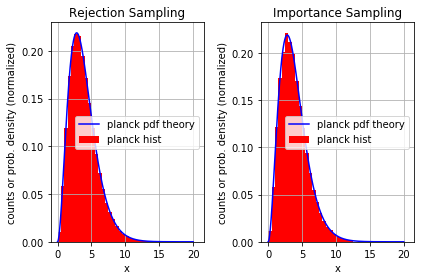

In [39]:
random.seed = 42
x_cut = 20
sampleRejection = []
counter1 = 0 # this variable counts the amount of rejected proposals
start_time = time.time()
while(len(sampleRejection) < 1e5): # < and not <= because arrays start at 0 in python
    x = x_cut * random.random() # This generates a random x from 0 to 20, 20 not included
    y = y_max * random.random()
    if y < planck(x):
        sampleRejection.append(x)
        counter1 += 1 # we add 1 because x has been generated but y cant be used for anything
    else:
        counter1 += 2 # we add 2 because x and y are generated        
print("--- %s seconds ---" % (time.time() - start_time), 'and', counter1, 'discarded random numbers for Rejection Sampling.')

sampleImportance = []
inverseMax = y_max * x_s - 2000/9 * 15/np.pi**4 * (np.exp(-1000**(0.9))-np.exp(-x_s**(0.9)))
# inverseMax is the limit of the cdf of the majorant as x tends to infty.
# It is used in the generation of our x because the majorant cant be a proper pdf.
# This is because it is always greater or equal than a normalized pdf. We hope this is at least somewhat correct...
counter2 = 0 
while(len(sampleImportance) < 1e5):
    x = 1.53*random.random() # This generates a random x from 0 to 1.53
    y = random.random()
    xStrich = inverseCDFOfMajorant(x, x_s, y_max)
    if y < planck(xStrich)/majorant(xStrich, x_s, y_max):
        sampleImportance.append(xStrich)
        counter1 += 1
    else:
        counter2 += 2
    
x_lin = np.linspace(0.001,20,1000) # we start at 0.001 (very close to zero and noticeable in the plot)
# because we want to avoid that python is unable to assign truths values elementwise.
plt.subplot(1,2,1)
plt.title('Rejection Sampling')
plt.hist(sampleRejection, bins=np.arange(start=0, stop=21, step=0.5), normed = True,
         histtype='bar', label='planck hist', color='r')
plt.plot(x_lin, planck(x_lin), 'b-', label='planck pdf theory')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('counts or prob. density (normalized)')
plt.subplot(1,2,2)
plt.title('Importance Sampling')
plt.hist(sampleImportance, bins=np.arange(start=0, stop=21, step=0.5), normed = True,
         histtype='bar', label='planck hist', color='r')
plt.plot(x_lin, planck(x_lin), 'b-', label='planck pdf theory')
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel('counts or prob. density (normalized)')
plt.tight_layout()
plt.show()